# Single-Cell RNA Seq Example

## Outline

- [Setup](#setup)
- [Understanding the mechanism of action of a drug using causal inference](#understanding-the-mechanism-of-action-of-a-drug-using-causal-inference)
    - [Data Source](#data-source)
    - [Data preprocessing](#data-preprocessing)
    - [Goal: Understand the effects that the cancer drug candidate Pracinostat SB939 has on the HDAC pathway](#goal-understand-the-effects-that-the-cancer-drug-candidate-pracinostat-sb939-has-on-the-hdac-pathway)
- [Causal Probabilistic Program](#causal-probabilistic-program)
    - [Model Description](#model-description)
    - [Reporting regression coefficients](#reporting-regression-coefficients)
    - [Predictions on unseen cells](#predictions-on-unseen-cells)
- [Computing causal queries](#computing-causal-queries)
    - [Imputing potential outcomes](#imputing-potential-outcomes)
    - [Causal Query: Average treatment effect (ATE)](#causal-query-average-treatment-effect-ate)
    - [Causal Query: Conditional average treatment effect (CATE)](#causal-query-conditional-average-treatment-effect-cate)
- [References](#references)





## Setup

Here, we install the necessary Pytorch, Pyro, and ChiRho dependencies for this example.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
!pip install scanpy pybiomart numpy==1.23 seaborn==0.12.2 ## add single cell dependencies

In [3]:
import os
import math
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
from pyro.infer.autoguide import AutoNormal
from pyro.nn import PyroModule
import pyro.distributions as dist
import torch

from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition

pyro.clear_param_store()
pyro.set_rng_seed(1234)
pyro.settings.set(module_local_params=True)

sns.set_style("white")

## Understanding the mechanism of action of a drug using causal inference

### Data Source

We analyze the SciPlex3 dataset from Srivatsan (2020), which consists of over 650K single-cell measurements (`X`) for three different cancer cell types (`cell_type`): MCF7, K562, and A549. Each cell in this dataset is unperturbed (`Vehicle`) or randomly treated with a drug from a library of 188 drug perburbations (`product_name`) at 4 different dosages (`dose`): $10^1, 10^2, 10^3, 10^4$ nM.

In [4]:
# Download raw data if doesn't already exist
if not os.path.exists("SrivatsanTrapnell2020_sciplex3_debugged.h5"):
    # Download and unzip 3 files files from here:
    # https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4150378
    # (1) GSM4150378_sciPlex3_A549_MCF7_K562_screen_UMI.count.matrix.gz
    # (2) GSM4150378_sciPlex3_A549_MCF7_K562_screen_gene.annotations.txt.gz
    # (3) GSM4150378_sciPlex3_pData.txt.gz

    # Cach raw zip files
    os.system(
        "wget -c https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4150nnn/GSM4150378/suppl/GSM4150378_sciPlex3_A549_MCF7_K562_screen_UMI.count.matrix.gz"
    )
    os.system(
        "wget -c https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4150nnn/GSM4150378/suppl/GSM4150378_sciPlex3_A549_MCF7_K562_screen_gene.annotations.txt.gz"
    )

    os.system(
        "wget -c https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4150nnn/GSM4150378/suppl/GSM4150378_sciPlex3_pData.txt.gz"
    )

    # unzip files
    os.system("gunzip GSM4150378_sciPlex3_A549_MCF7_K562_screen_UMI.count.matrix.gz")
    os.system("gunzip GSM4150378_sciPlex3_A549_MCF7_K562_screen_gene.annotations.txt.gz")
    os.system("gunzip GSM4150378_sciPlex3_pData.txt.gz")
    
    # Run processing script to save as h5 file
    os.system("python SrivatsanTrapnell2020.py") # outputs files as SrivatsanTrapnell2020_sciplex3_debugged.h5

In [5]:
# Data is 12GB
!du -sh *h5

 12G	SrivatsanTrapnell2020_sciplex3_debugged.h5


### Data preprocessing

We preprocess the data as follows:
- Filter out cells that have unknown cell type
- Only include measurements at the 24hr timepoint (retains ~90% of the dataset)
- Restrict to human genes since all cells are from human cell lines
- Filter out genes that are expressed in fewer than 10 cells
- Filter out cells that have fewer than 200 expressed genes
- Mitochondrial ratio quality (based on visual inspection)
- Read counts

In [6]:
# Load in sciplex3 study data as anndata

anndata = sc.read_h5ad("SrivatsanTrapnell2020_sciplex3_debugged.h5")

/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
# Remove unknown cell types
anndata = anndata[~anndata.obs['cell_type'].isnull()]

# Filter out to only 24hr observations (~90% of the data remains)
anndata = anndata[anndata.obs['time_point'] == 24]

# Restrict to genes in human genome
annot = sc.queries.biomart_annotations(
    "hsapiens", ["ensembl_gene_id", "hgnc_symbol"]
)
annot = annot.dropna()
anndata = anndata[:, anndata.var['ensembl_gene_id'].isin(annot['ensembl_gene_id'].values)]

# Filter out genes that are expressed in less than 10 cells
sc.pp.filter_genes(anndata, min_cells=10)

# Filter out cells that express less than 200 genes
sc.pp.filter_cells(anndata, min_genes=200)

/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


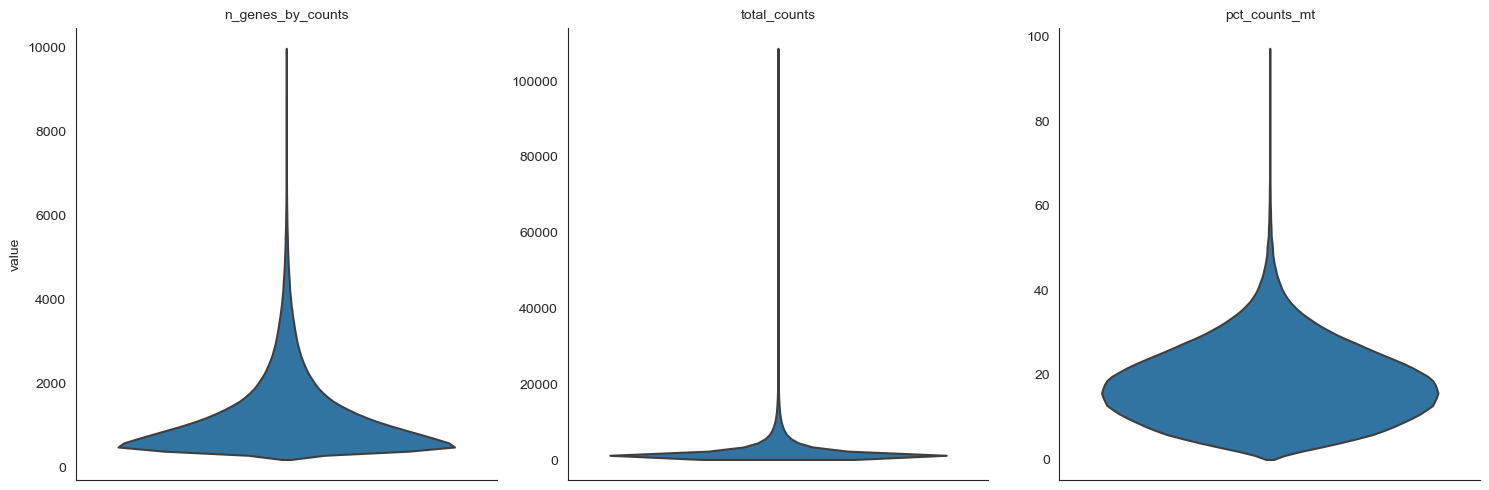

In [8]:
# Trim outliers by 
# 1. Mitochondrial ratio quality 
# 2. total read counts
# 3. number of genes per cell
anndata.var["mt"] = anndata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    anndata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

anndata.var_names_make_unique()
# Quality plots to identify outliers
sc.pl.violin(
    anndata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.3,
    multi_panel=True,
    stripplot=False
)

In [9]:
# define outliers and do the filtering for the sciplex data
# with arbitrary cutoffs 
anndata.obs['outlier_mt'] = anndata.obs.pct_counts_mt > 60
anndata.obs['outlier_total'] = anndata.obs.total_counts > 20000
anndata.obs['outlier_ngenes'] = anndata.obs.n_genes_by_counts > 6000

print('%u cells with high %% of mitochondrial genes' % (sum(anndata.obs['outlier_mt'])))
print('%u cells with large total counts' % (sum(anndata.obs['outlier_total'])))
print('%u cells with large number of genes' % (sum(anndata.obs['outlier_ngenes'])))

anndata = anndata[~anndata.obs['outlier_mt'], :]
anndata = anndata[~anndata.obs['outlier_total'], :]
anndata = anndata[~anndata.obs['outlier_ngenes'], :]
sc.pp.filter_genes(anndata, min_cells=1)

655 cells with high % of mitochondrial genes
2713 cells with large total counts
1481 cells with large number of genes


/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


### Goal: Understand the effects that the cancer drug candidate Pracinostat SB939 has on the HDAC pathway

We choose a particular drug (Pracinostat (SB939)), which is currently in a Phase II clinical trial for treating T cell lymphoma. We start our analysis by looking at several summary statistics and visualizations of this drug. Then, we use `ChiRho` to estimate the causal effect of this drug on gene expression levels.



In [37]:
anndata.obs[anndata.obs.product_name.str.contains("Pracin")][['target']].drop_duplicates().reset_index(drop=True)

,target
0,HDAC


Histone deacetylase (HDAC) inhibitors are anti-cancer agents that can induce death, apoptosis, and cell cycle arrest in cancer cells Kim (2011). As shown above, Pracinostat (SB939) targets the HDAC pathway, which consists of 18 genes (`hdac_genes`) based on the HUGO Gene Nomenclature Committee. We focus on modeling the changes in  expression of these 18 genes in response to Pracinostat (SB939). We remove genes that has low variance across cells based on pearson residual based variance (see below) which leaves 14/18 of these genes remaining. 

#### Exploratory data analysis

In [14]:
# Different subgroups part of the histone deacetylase family from HUGO Gene Nomenclature Committee (see references for link)
sirt = ["SIRT1", "SIRT2", "SIRT3", "SIRT4", "SIRT5", "SIRT6", "SIRT7"]
class_one = ["HDAC1", "HDAC2", "HDAC3", "HDAC8"]
class_two_a = ["HDAC4", "HDAC5", "HDAC7", "HDAC9"]
class_two_b = ["HDAC6", "HDAC10"]
class_four = ["HDAC11"]
hdac_genes = sirt + class_one + class_two_a + class_two_b + class_four

drug_target = "Pracinostat (SB939)"
drug_data = anndata[anndata.obs.product_name.str.contains("Pracinostat|Vehi")]

In [29]:
# Use pearson residuals for better gene visualization (see ADD REF)
sc.experimental.pp.highly_variable_genes(
    drug_data, flavor="pearson_residuals", n_top_genes=10000
)

/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/scanpy/experimental/pp/_highly_variable_genes.py:67: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


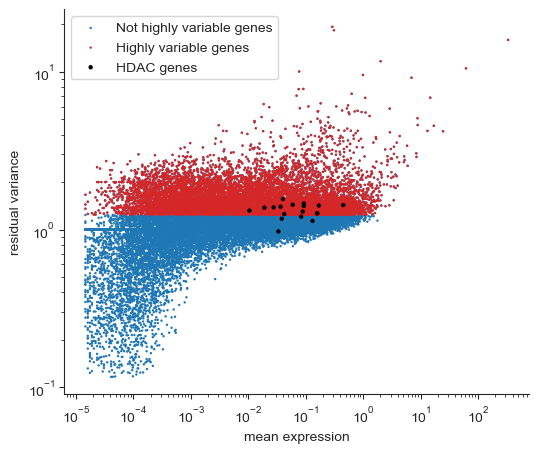

In [30]:
fig, ax = plt.subplots(1, figsize=(6, 5))

hvgs = drug_data.var["highly_variable"]

ax.scatter(
    drug_data.var["mean_counts"], drug_data.var["residual_variances"], s=3, edgecolor="none",
    label='Not highly variable genes'
)
ax.scatter(
    drug_data.var["mean_counts"][hvgs],
    drug_data.var["residual_variances"][hvgs],
    c="tab:red",
    label="Highly variable genes",
    s=3,
    edgecolor="none",
)
ax.scatter(
    drug_data.var["mean_counts"][hdac_genes],
    drug_data.var["residual_variances"][hdac_genes],
    c="k",
    label="HDAC genes",
    s=10,
    edgecolor="none",
)

ax.set_xscale("log")
ax.set_xlabel("mean expression")
ax.set_yscale("log")
ax.set_ylabel("residual variance")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

ax.legend()

In [31]:
# Filter to highly variable genes
drug_data = drug_data[:, drug_data.var["highly_variable"]]

# Remove low variance genes in HDAC pathway based on pearsone residuals
hdac_genes = np.intersect1d(hdac_genes, drug_data.var_names[drug_data.var.highly_variable])

Let's look at how each cell clusters based on cell type and if the cell was given the drug or not using a Uniform Manifold Approximation and Projection (UMAP) embedding of the highly variable genes.

In [ ]:
# The UMAP function does a visualization using 'X' in the anndata object
# We save the raw counts for later use
drug_data.layers["raw"] = drug_data.X.copy()

# Now, 'X' refers to pearson residuals 
sc.experimental.pp.normalize_pearson_residuals(drug_data)

# Log1p normalize of the data (used for UMAP visual)
drug_data.layers["log1p"] = np.log1p(
    sc.pp.normalize_total(drug_data, inplace=False)["X"]
)

sc.pp.neighbors(drug_data, n_neighbors=30, n_pcs=30)
sc.tl.umap(drug_data)

In the UMAP latent space, we see a clear clustering of cells around both cell type and if the cell was given the drug or not.

/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


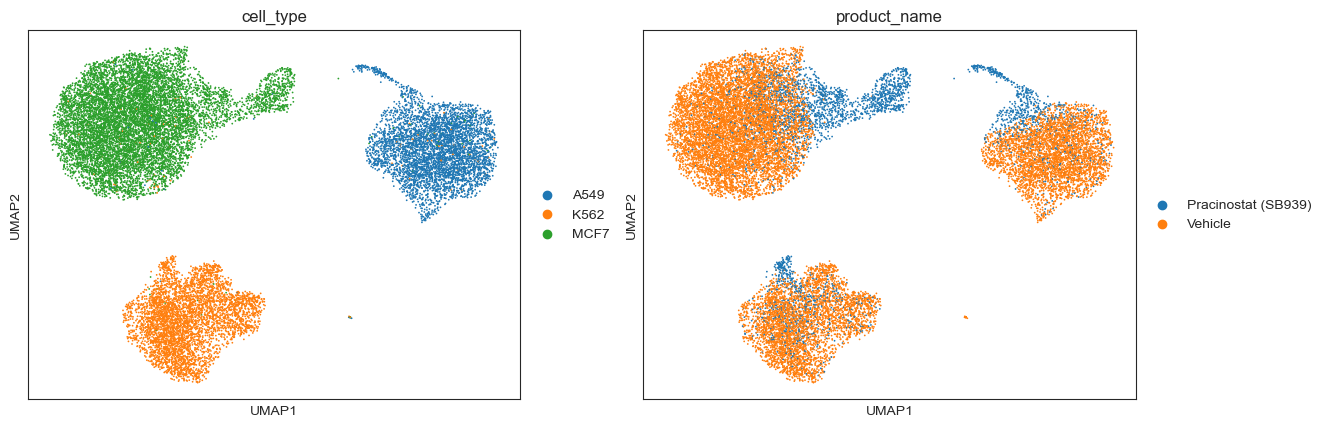

In [58]:
# Visualize expression pattern per cell in UMAP
sc.pl.umap(drug_data, layer='log1p',
           color=['cell_type', 'product_name'])

Let's look at how each of these genes are expressed in the dataset. We plot the distribution of log expression levels for each gene, stratified by cell type and log treatment dosages. We see that the expression levels of these genes vary across cell types, and that treatment with Pracinostat (SB939) induces changes in expression levels for some genes but not others.

In [61]:
def plot_average_expression(data, gene_names):    
    drug_expression_df = pd.DataFrame(data[:, gene_names].layers['log1p'].toarray(), columns=gene_names)
    drug_expression_df['log10dose'] = np.log10(data.obs['dose'].values)
    drug_expression_df = drug_expression_df.replace(-np.inf, 0)
    data.obs['log10dose'] = drug_expression_df['log10dose'].values
    drug_expression_df['cell_type'] = data.obs['cell_type'].values
    avg_expression = drug_expression_df.groupby(by=['cell_type', 'log10dose']).mean().reset_index()
    avg_expression = avg_expression.melt(id_vars=['cell_type', 'log10dose'])
    avg_expression.rename({'variable': 'gene_name', 'value': 'avg_expression'}, inplace=True, axis=1)
    
    fig, ax = plt.subplots(2, 7, figsize=(24, 8))
    
    for i, gene in enumerate(gene_names):
        curr_ax = ax[i // 7][i % 7]
        if gene in avg_expression.gene_name.values:
            sns.lineplot(data=avg_expression[avg_expression.gene_name == gene],
                         x='log10dose', y='avg_expression', hue='cell_type', ax=curr_ax, marker='o')
            curr_ax.set_title(gene)
            curr_ax.set_xlabel('Log Dose')
            curr_ax.set_ylabel('Log Expression')
            curr_ax.legend(loc='upper left')
    plt.tight_layout()

/var/folders/1n/rv21b_n10gx0tp5_zz33z7qc0000gn/T/ipykernel_20933/927555890.py:3: RuntimeWarning: divide by zero encountered in log10
  drug_expression_df['log10dose'] = np.log10(data.obs['dose'].values)


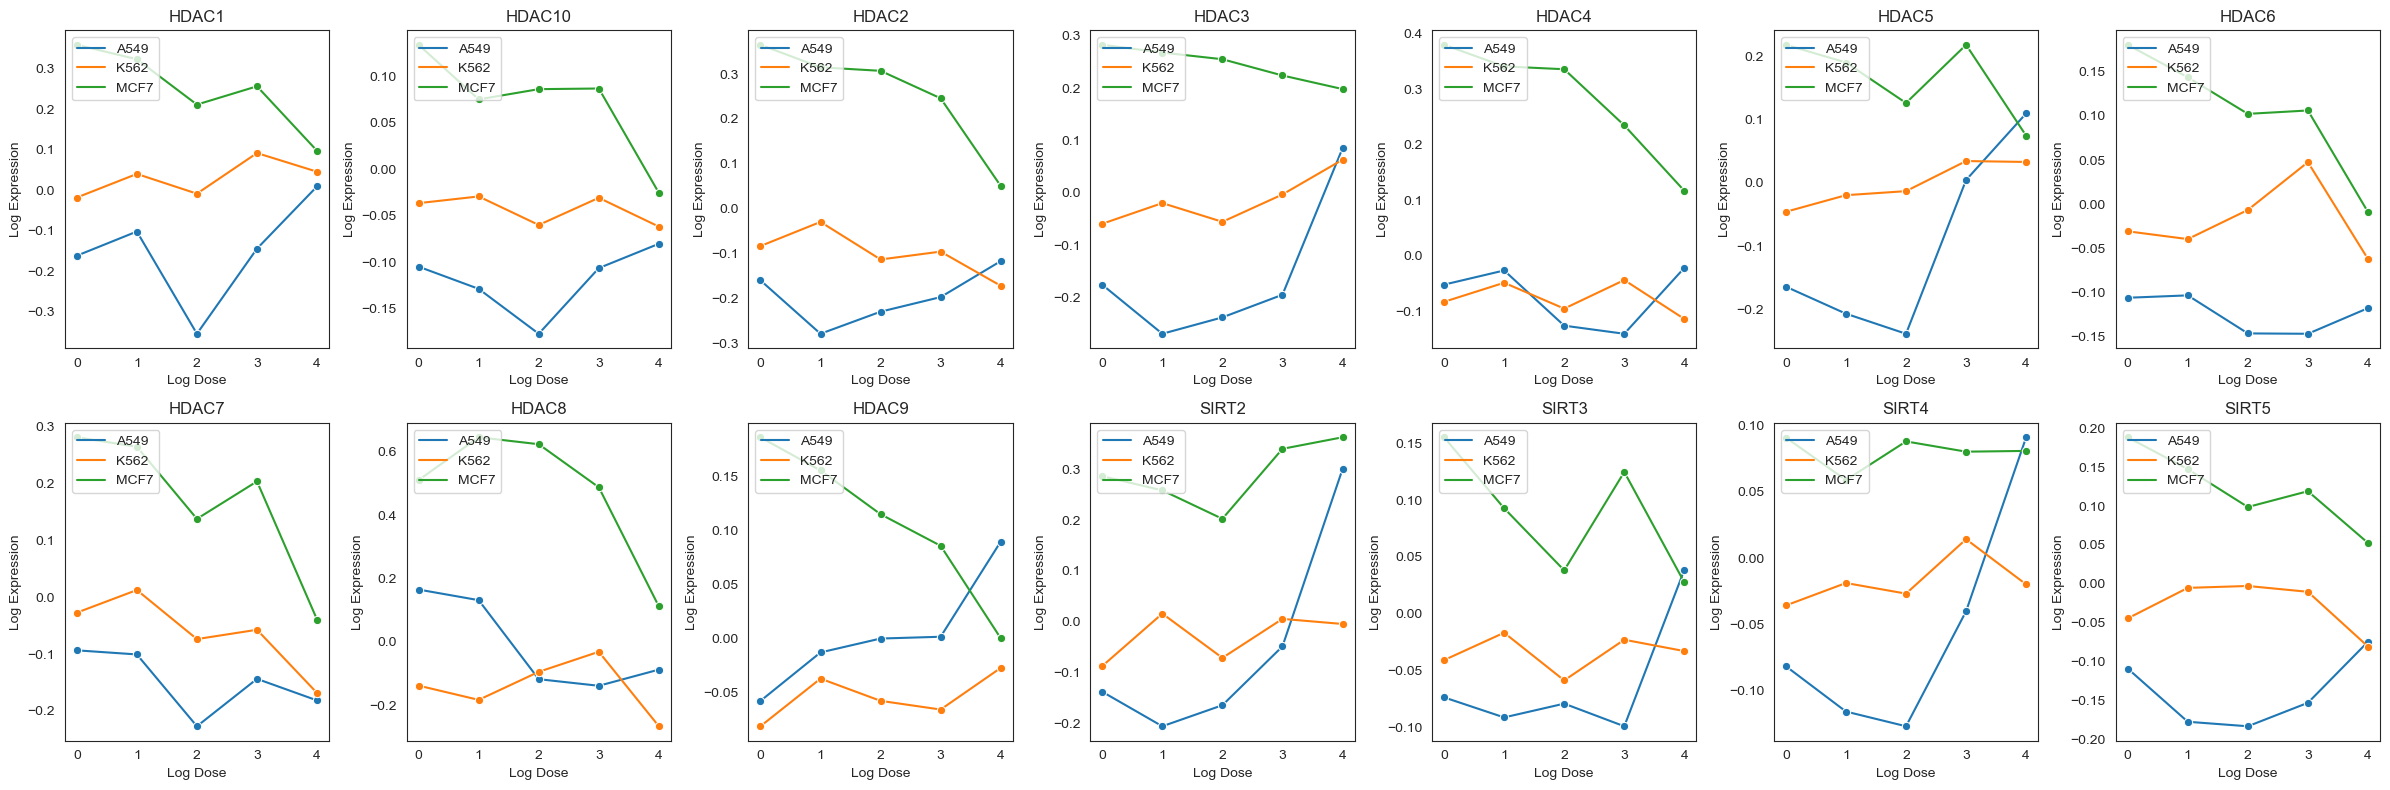

In [62]:
plot_average_expression(drug_data, hdac_genes)

Pracinostat (SB939) is biologically known to be an inhibitor of genes in the HDAC pathway. So we would expect that dosage is negatively correlated with expression levels. However, the plots above suggest that Pracinostat (SB939) sometimes increases expression levels for certain cell types. This correlation might be due to uncontrolled confounding factors (e.g., technical artifacts, batch effects, etc.) or off-target effects. In the next part, we use `ChiRho` to estimate the causal effect of Pracinostat (SB939) on the expression levels of these genes by controlling for these confounding factors.

## Causal Probabilistic Program

### Model Description
In the plots above, we did not control for technical covariates (e.g., cell plate, replicate number, etc.). Here we fit a generalized linear model with Poission likelihood to account for the heavy-tailed count nature of the data. We also include interactions between genes and confounders (e.g., cell type, read depth, etc.) to understand how treatment effects vary across cell types and experimental conditions. Our model is defined as follows:

$$
\begin{align*}
    \mu &\sim \mathcal{N}(0, 1) \quad (\text{intercept}) \\
    \tau_{g} &\sim \mathcal{N}(0, 1) \quad (\text{average treatment effect}) \\
    \theta_{gi} &\sim \mathcal{N}(0, 1 / \sqrt{p}), \quad{1 \leq i \leq p} \quad (\text{confounder effect}) \\
    \eta_{gi} &\sim \mathcal{N}(0, 1 / \sqrt{p}), \quad{1 \leq i \leq p} \quad (\text{heterogeneous treatment effect}) \\
    \log \mu_{ng} &= \mu + \tau_{g} T_n + \theta_{g}^T X_n + \eta_{g}^T (X_n \odot T_n) \\
    Y_{ng} &\sim \text{Poisson}(\mu_{ng}) \\

\end{align*}
$$
where $\odot$ denotes elementwise multiplication, $p$ the number of confounders, $T_n$ treatment, $X_n$ confounders, and $Y_{ng}$ gene expression counts for cell $n$ and gene $g$.

In [161]:
class DrugPerturbationModel(PyroModule):
    def __init__(self, num_cells: int, num_genes: int, num_confounders: int):
        super().__init__()
        self.num_cells = num_cells
        self.num_genes = num_genes
        self.num_confounders = num_confounders

    def forward(self, mask: bool = False):
        prior_variance = 1 / math.sqrt(self.num_confounders)
        propensity_weights = pyro.sample("propensity_weights", dist.Normal(0, prior_variance).expand((self.num_confounders, )).to_event(1))

        # Sample regression weights for each gene
        gene_plate = pyro.plate("genes", self.num_genes, dim=-1)
        with gene_plate:
            intercept = pyro.sample("intercept", dist.Normal(0, 1))
            theta_confounders = pyro.sample("theta_confounders", dist.Normal(0, prior_variance).expand((self.num_confounders,)).to_event(1)) # G x F
            theta_drug = pyro.sample("theta_drug", dist.Normal(0, 1))
            theta_confounders_drug = pyro.sample("theta_confounders_drug", dist.Normal(0, prior_variance).expand((self.num_confounders,)).to_event(1)) # G x F
         
        # Compute likelihood
        with pyro.plate("samples", self.num_cells, dim=-2):
            # Sample treatment and confounders (remove from log_prob since we'll always conditioned on them when mask = False)
            confounders = pyro.sample("confounders", dist.Normal(0, 1).expand((self.num_confounders,)).mask(mask).to_event(1))
            treatment_mean = torch.einsum("...ngp,...p->...ng", confounders, propensity_weights)
            T = torch.relu(pyro.sample("drug", dist.Normal(treatment_mean, 1)))
            with gene_plate:
                # Confounding effects
                confounder_variation = intercept + torch.einsum("...ngp,...gp->...ng", confounders, theta_confounders) # N x G

                # Drug dose treatment effects
                treatment_variation = theta_drug * T + torch.einsum("...ngp,...ng,...gp->...ng", confounders, T, theta_confounders_drug) # N x G
                mean = confounder_variation + treatment_variation # N x G
                expressions = pyro.sample("gene_expression", dist.Poisson(rate=torch.exp(mean)))
        return expressions


class ConditionedDrugModel(PyroModule):
    def __init__(self, model: DrugPerturbationModel):
        super().__init__()
        self.model = model

    def forward(self, X, T, Y, **kwargs):
        with condition(data=dict(confounders=X[:, None, :], drug=T[..., None], gene_expression=Y)):
            return self.model(**kwargs)


def run_svi_inference(model, n_steps=1000, verbose=True, lr=0.03, **model_kwargs):
    guide = AutoNormal(pyro.poutine.block(model, hide_fn=lambda site: site["type"] == "sample" and site["name"] is not None and (site["name"].startswith("gene_expression") or site["name"].startswith("drug") or site["name"].startswith("confounders"))))
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    # initialize parameters
    elbo(**model_kwargs)
    adam = torch.optim.Adam(elbo.parameters(), lr=lr)
    # Do gradient steps
    for step in range(1, n_steps + 1):
        adam.zero_grad()
        loss = elbo(**model_kwargs)
        loss.backward()
        adam.step()
        if (step % 250 == 0) or (step == 1) & verbose:
            print("[iteration %04d] loss: %.4f" % (step, loss))
    return guide    

In [162]:
hdac_adata = drug_data[:, hdac_genes]

# Make data matrices
X_confounders = pd.get_dummies(hdac_adata.obs[['cell_type', 'replicate', 'culture_plate', 'pcr_plate', 'well_oligo']], dtype=np.int32).reset_index(drop=True)

# Control for sequencing depth
log_umi = np.log(hdac_adata.obs['n.umi'].values)
scaled_log_umi = (log_umi - np.mean(log_umi)) / log_umi.std()
X_confounders['depth_proxy'] = scaled_log_umi

# For each drug, input log dose as a feature
T_all = pd.get_dummies(hdac_adata.obs[['product_name']], dtype=np.int32).reset_index(drop=True)
T_all = T_all.mul(np.log10(hdac_adata.obs['dose'].values + 1), axis=0)

# Get response for all gene expressions in HDAC pathway
Y_hdac = torch.tensor(hdac_adata[:, hdac_genes].layers['raw'].toarray(), dtype=torch.float32)

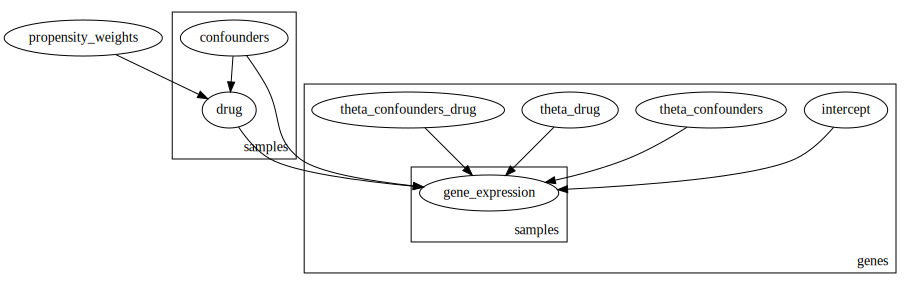

In [163]:
# Render model
model = DrugPerturbationModel(num_cells=X_confounders.shape[0], num_genes=Y_hdac.shape[1], num_confounders=X_confounders.shape[1])

# Visualize model
pyro.render_model(
    model, 
    model_args=(
        True, # so that arrows get rendered correctly
    ), 
    render_params=True, 
    render_distributions=False
)

### Reporting regression coefficients

Here we report the average treatment effect parameter `theta_drug`. Note that this parameter is harder to interpret because it represents deviations on the log transformed scale instead of the original count scale. In the next section, we will estimate average treatment effects on the original count measurement scales.

In [164]:
drug_control_mask = torch.tensor(hdac_adata.obs['product_name'].isin(['Vehicle', drug_target]).values)
T_drug_control = torch.tensor(T_all[f'product_name_{drug_target}'].values, dtype=torch.float32)[drug_control_mask]
X_drug_control = torch.tensor(X_confounders.values[drug_control_mask], dtype=torch.float32)
Y_drug_control = Y_hdac[drug_control_mask]

# Split into training and test set
N_drug_control = X_drug_control.shape[0]
train_mask = torch.tensor(np.random.choice([True, False], size=N_drug_control, p=[0.8, 0.2]))
X_train = X_drug_control[train_mask]
T_train = T_drug_control[train_mask]
Y_train = Y_drug_control[train_mask]
X_test = X_drug_control[~train_mask]
T_test = T_drug_control[~train_mask]
Y_test = Y_drug_control[~train_mask]

In [165]:
model = ConditionedDrugModel(
        DrugPerturbationModel(num_cells=Y_train.shape[0], num_genes=Y_train.shape[1], num_confounders=X_train.shape[1])
)

guide = run_svi_inference(model, n_steps=2000, verbose=True, X=X_train, T=T_train, Y=Y_train)

[iteration 0001] loss: 252110.5000
[iteration 0250] loss: 75379.7266
[iteration 0500] loss: 74237.6406
[iteration 0750] loss: 73760.9297
[iteration 1000] loss: 73633.9219
[iteration 1250] loss: 73429.7031
[iteration 1500] loss: 73360.6016
[iteration 1750] loss: 73361.5781
[iteration 2000] loss: 73309.6875


In [166]:
drug_model = ConditionedDrugModel(
    DrugPerturbationModel(num_cells=Y_test.shape[0], num_genes=Y_test.shape[1], num_confounders=X_test.shape[1])
)

predictive = pyro.infer.Predictive(drug_model, guide=guide, num_samples=500)

predictive_samples = predictive(X=X_test, T=T_test, Y=None)

In [167]:
avg_treat_effects_by_gene = pd.DataFrame(predictive_samples['theta_drug'].squeeze(), 
                                         columns=hdac_genes)

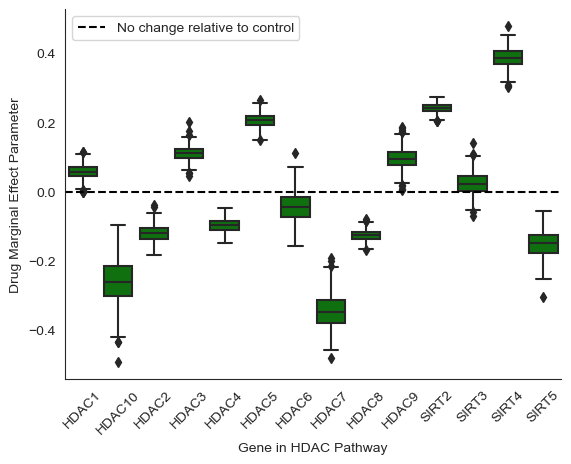

In [168]:
sns.boxplot(data=avg_treat_effects_by_gene, color='green')
plt.axhline(0, color='black', linestyle='--', label='No change relative to control')
plt.xlabel('Gene in HDAC Pathway')
plt.xticks(rotation=45)
plt.ylabel('Drug Marginal Effect Parameter')
plt.legend()
sns.despine()

### Predictions on unseen cells

As we see below, our predictions of gene expressions are quite poor. However, this is not very suprising because we are using a linear model, and not conditioning on more cell and gene features.

In [169]:
test_avg = predictive_samples['gene_expression'].mean(dim=0)
test_q05 = torch.quantile(predictive_samples['gene_expression'], .05, dim=0)
test_q50 = torch.quantile(predictive_samples['gene_expression'], .5, dim=0)
test_q95 = torch.quantile(predictive_samples['gene_expression'], .95, dim=0)

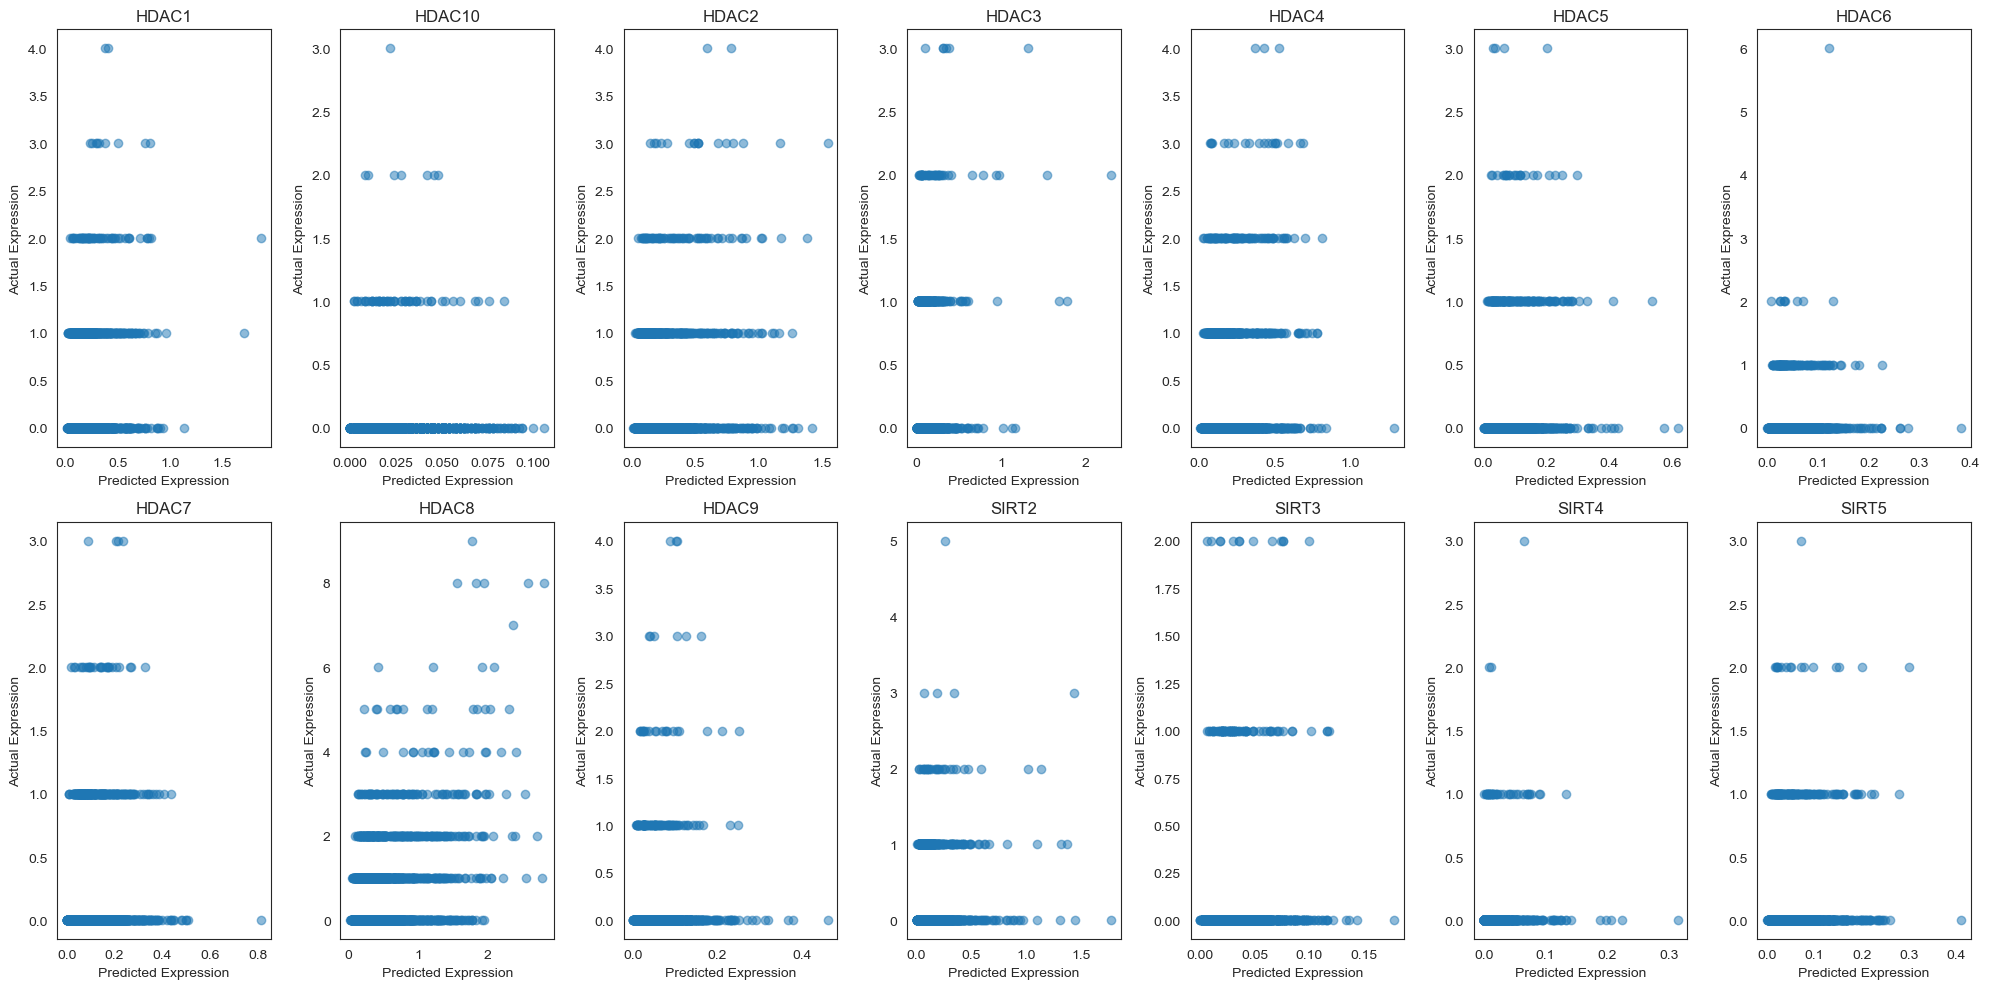

In [170]:
# Compare posterior mean predictions across 13 genes 
fig, ax = plt.subplots(2, 7, figsize=(20, 10))

for i, gene in enumerate(hdac_genes):
    curr_ax = ax[i // 7][i % 7]
    curr_ax.scatter(test_avg[:, i], Y_test[:, i], alpha=0.5)
    curr_ax.set_title(gene)
    curr_ax.set_xlabel('Predicted Expression')
    curr_ax.set_ylabel('Actual Expression')

plt.tight_layout()

Often, we are not able to accurately predict expressions for individual cells as the above plot shows. However, many papers evaluate at the bulk level (i.e., comparing how well the model predicts the mean expression across a collection of similar cells) since we often care about the effect a drug at a coarser level, namely at the tissue level.

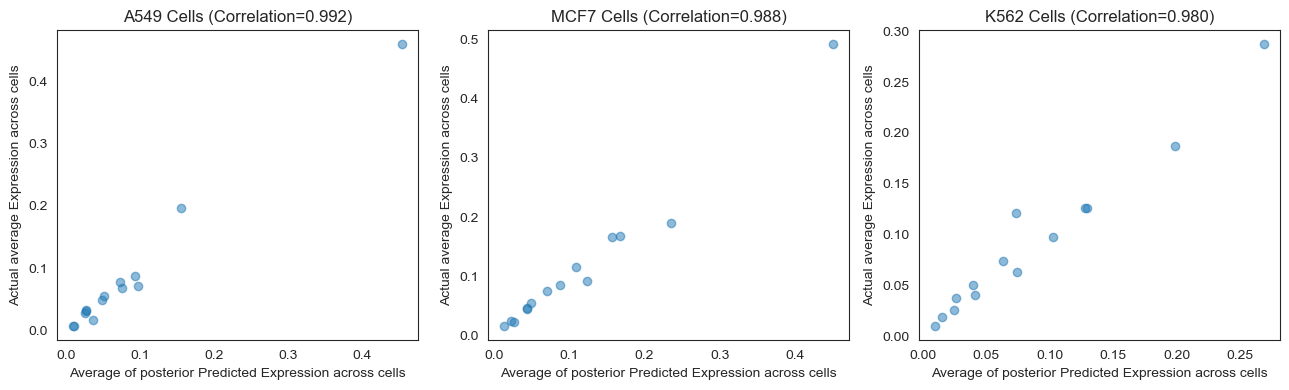

In [171]:
from scipy.stats import pearsonr

# Compare posterior mean predictions across 14 genes 
# Average gene expression comparison https://www.nature.com/articles/s41592-019-0494-8/figures/2

# Segment by cell type
fig, ax = plt.subplots(1, 3, figsize=(13, 4))
for i, cell_type in enumerate(['A549', 'MCF7', 'K562']):
    cell_type_mask = torch.tensor(hdac_adata[~train_mask.numpy()].obs['cell_type'].values == cell_type)
    test_avg_bulk = test_avg[cell_type_mask].mean(dim=0)

    ax[i].scatter(test_avg_bulk, Y_test[cell_type_mask].mean(dim=0), alpha=0.5)
    ax[i].set_xlabel('Average of posterior Predicted Expression across cells')
    ax[i].set_ylabel('Actual average Expression across cells')
    ax[i].set_title(f'{cell_type} Cells (Correlation={pearsonr(test_avg_bulk, Y_test[cell_type_mask].mean(dim=0))[0]:.3f})')
    plt.tight_layout()

Once we look at how our model performs at the bulk tissue level, we see that the predictions are quite good. 

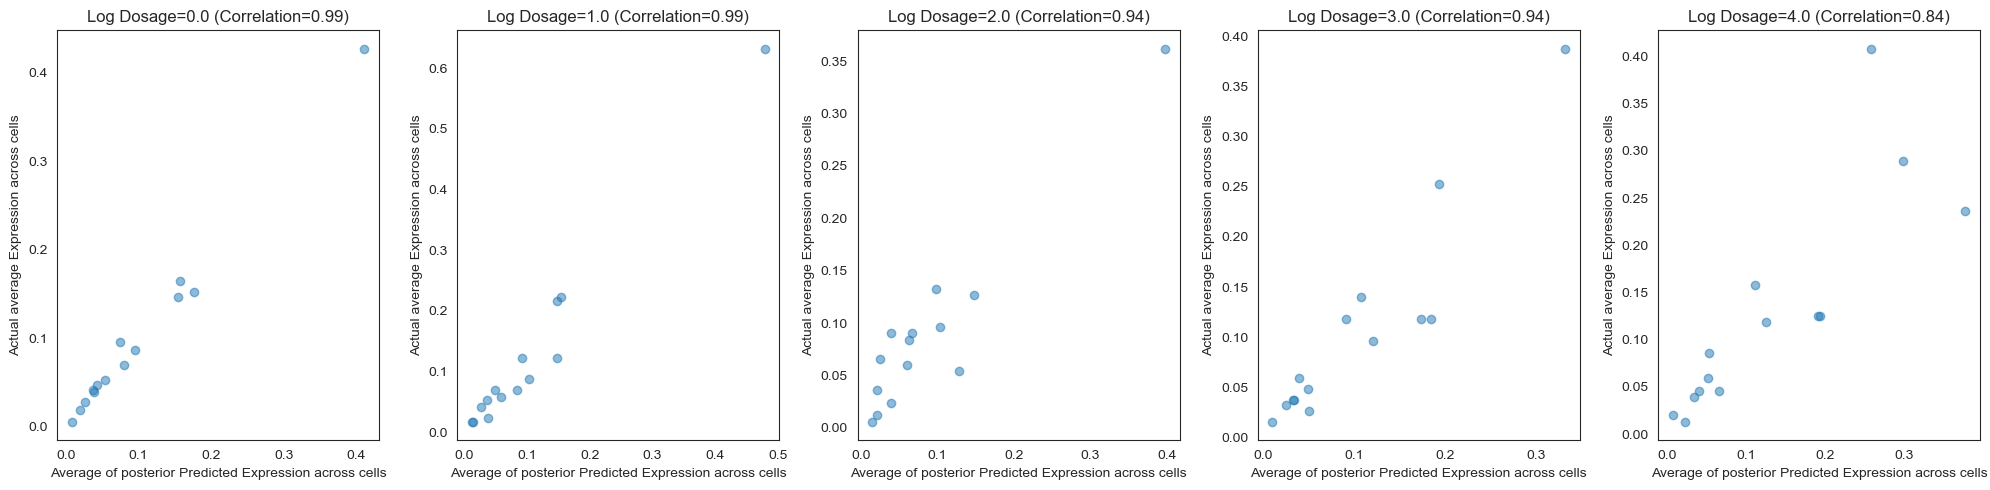

In [172]:
# Group cells by log dosage and then compare average expressions with the model
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i, log_dose_level in enumerate([0., 1., 2., 3., 4.]):
    dose_level_mask = torch.isclose(T_test, torch.tensor(log_dose_level), atol=.2)
    test_avg_bulk = test_avg[dose_level_mask].mean(dim=0)

    ax[i].scatter(test_avg_bulk, Y_test[dose_level_mask].mean(dim=0), alpha=0.5)
    ax[i].set_xlabel('Average of posterior Predicted Expression across cells')
    ax[i].set_ylabel('Actual average Expression across cells')
    ax[i].set_title(f'Log Dosage={log_dose_level} (Correlation={pearsonr(test_avg_bulk, Y_test[dose_level_mask].mean(dim=0))[0]:.2f})')
plt.tight_layout()

## Computing causal queries

We impute counterfactuals for each cell and gene to compute causal summaries of interest. Specifically, let $Y_{ng}(T)$ denote the expression potential outcome for dosage $T$, cell $n$, and gene $g$, where $T \in \{0, 10^1, 10^2, 10^3, 10^4\}$. For cell $n$, we only observe the potential outcome $Y_{ng}(\cdot)$ at a particular dosage $T_n$. So we impute the potential outcome $Y_{ng}(T)$ for all $T \neq T_n$. Of course, since we only observe each cell once, there is non-trivial uncertainity in the imputed potential outcomes. However, we can reduce this uncertainty by aggregating the estimated potential outcomes into summaries of interest. For example, we can estimate the average treatment effect (ATE) at dose $T > 0$ for gene $g$ as follows:

$$
\widehat{\text{ATE}}(T) = \frac{1}{N} \sum_{n=1}^N \hat{Y}_{ng}(T) - \hat{Y}_{ng}(0)
$$

where $N$ is the number of cells and $\hat{Y}_{ng}(T^{\prime})$ is the imputed counterfactual. We can also estimate the conditional average treatment effect (CATE) in a similar fashion. For example, we can compute the conditional average treatment effect of the drug on cell type $c$ as follows:

$$
\widehat{\text{CATE}}(T, c) = \frac{1}{N_c} \sum_{n=1}^N [\hat{Y}_{ng}(T) - \hat{Y}_{ng}(0)]I(\text{cell type}_n = c)
$$

where $N_c$ is the number of cells of cell type $c$.

### Imputing potential outcomes

To impute potential outcomes, we use our fitted Bayesian model and ChiRho's `MultiWorldCounterfactual` and `do` operators.

In [173]:
# Here we impute potential outcomes for each datapoint at a specified dosage level
class ImputePotentialOutcome(pyro.nn.PyroModule):
    def __init__(self, conditioned_model: ConditionedDrugModel):
        super().__init__()
        self.conditioned_model = conditioned_model

    def forward(self, dose_level: float, X: torch.tensor, T: torch.tensor, Y: torch.tensor, dose_epsilon: float = .2):
        T_level = dose_level * torch.ones(X.shape[0])

        with MultiWorldCounterfactual(), do(actions={"drug": T_level[..., None]}):
            expressions = self.conditioned_model(X, T, Y)
            expressions_cf = gather(expressions, IndexSet(drug={1})) # expressions predicted by model
            pyro.deterministic("expressions_po", expressions_cf.squeeze())

In [174]:
po_impute_model = ImputePotentialOutcome(ConditionedDrugModel(
        DrugPerturbationModel(num_cells=Y_drug_control.shape[0], num_genes=Y_drug_control.shape[1], num_confounders=X_drug_control.shape[1])
))

po_impute_predictive = pyro.infer.Predictive(po_impute_model, guide=guide, num_samples=500, parallel=True)

# Impute confounterfactuals at each log dose level
po_0_prediction = po_impute_predictive(0., X_drug_control, T_drug_control, Y_drug_control)['expressions_po'].squeeze()
po_1_prediction = po_impute_predictive(1., X_drug_control, T_drug_control, Y_drug_control)['expressions_po'].squeeze()
po_2_prediction = po_impute_predictive(2., X_drug_control, T_drug_control, Y_drug_control)['expressions_po'].squeeze()
po_3_prediction = po_impute_predictive(3., X_drug_control, T_drug_control, Y_drug_control)['expressions_po'].squeeze()
po_4_prediction = po_impute_predictive(4., X_drug_control, T_drug_control, Y_drug_control)['expressions_po'].squeeze()

### Causal Query: Average treatment effect (ATE)

In [175]:
def conditional_avg_treatment(po_t, po_0, mask):
    po_t = po_t[:, mask, :]
    po_0 = po_0[:, mask, :]
    cate = (po_t - po_0).mean(dim=1) # average over datapoints at dim=1
    return cate # number posterior samples x number genes

def average_treatment_effect(po_t, po_0):
    mask = torch.tensor([True] * po_t.shape[1])
    return conditional_avg_treatment(po_t, po_0, mask)

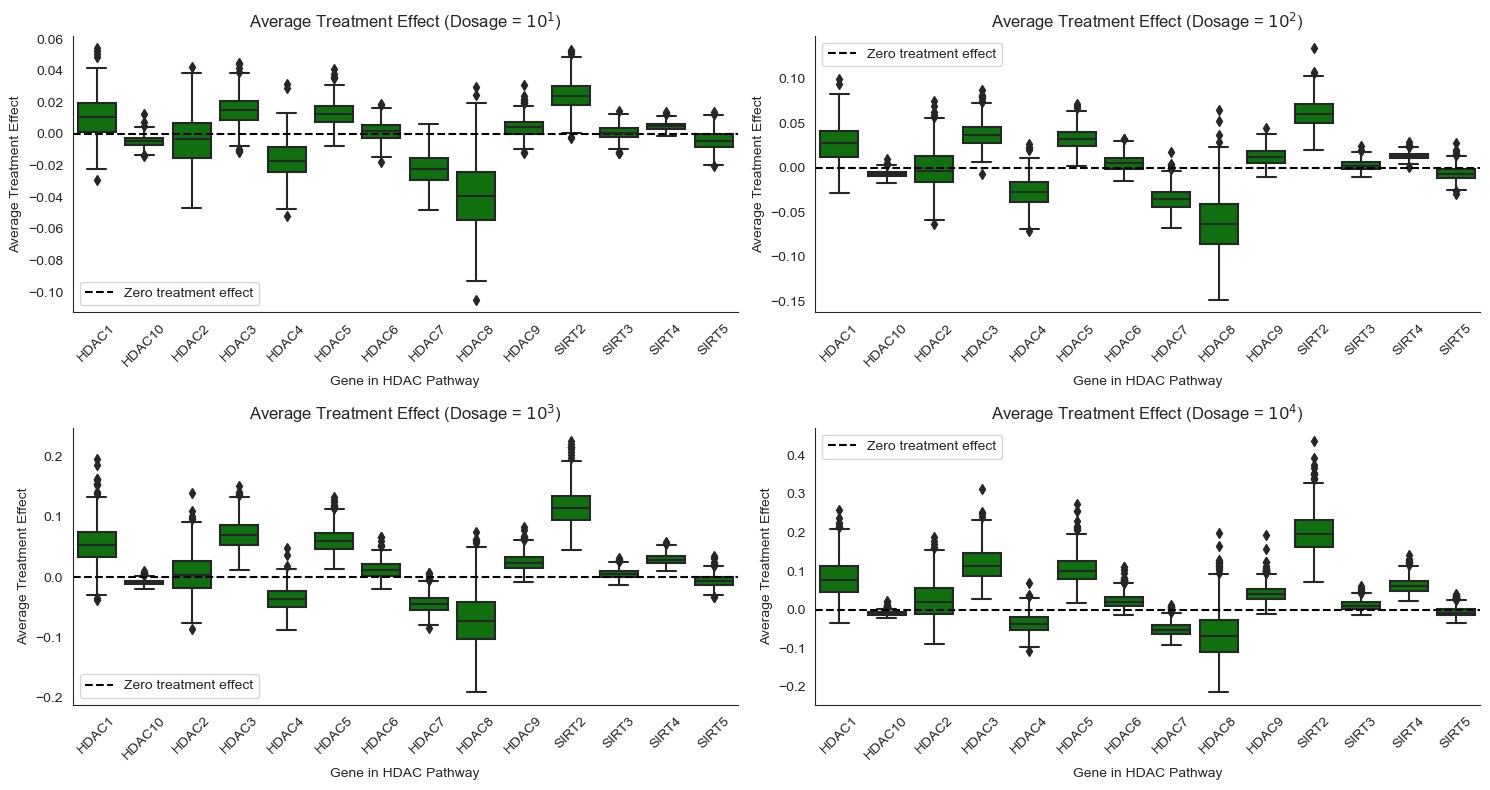

In [176]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

ates = [
    average_treatment_effect(po_1_prediction, po_0_prediction),
    average_treatment_effect(po_2_prediction, po_0_prediction),
    average_treatment_effect(po_3_prediction, po_0_prediction),
    average_treatment_effect(po_4_prediction, po_0_prediction),       
]

for i, dose_level in enumerate([1, 2, 3, 4]):
    curr_ax = ax[i // 2][i % 2]
    sns.boxplot(pd.DataFrame(ates[i], columns=hdac_genes), color='green', ax=curr_ax)
    curr_ax.set_title(f'Average Treatment Effect (Dosage = $10^{dose_level}$)')
    curr_ax.axhline(0, color='black', linestyle='--', label='Zero treatment effect')
    curr_ax.set_xlabel('Gene in HDAC Pathway')
    for tick in curr_ax.get_xticklabels():
        tick.set_rotation(45)
    curr_ax.set_ylabel('Average Treatment Effect')
    curr_ax.legend()
    sns.despine()

plt.tight_layout() 


The plot above provides the uncertainity across the average treatment effect for each gene. The upper and lower lines on each boxplot form a 50% credible interval for the average treatment effect. Although Pracinostat (SB939) is an inhibitor, the drug sometimes is estimated to increase expression levels in certain genes. For example, SIRT2 exhibits the largest positive effect. This finding is consistent with Srivatsan (2020) (see Figure 5b), and is likely due to off-target effects.

### Causal Query: Conditional average treatment effect (CATE)

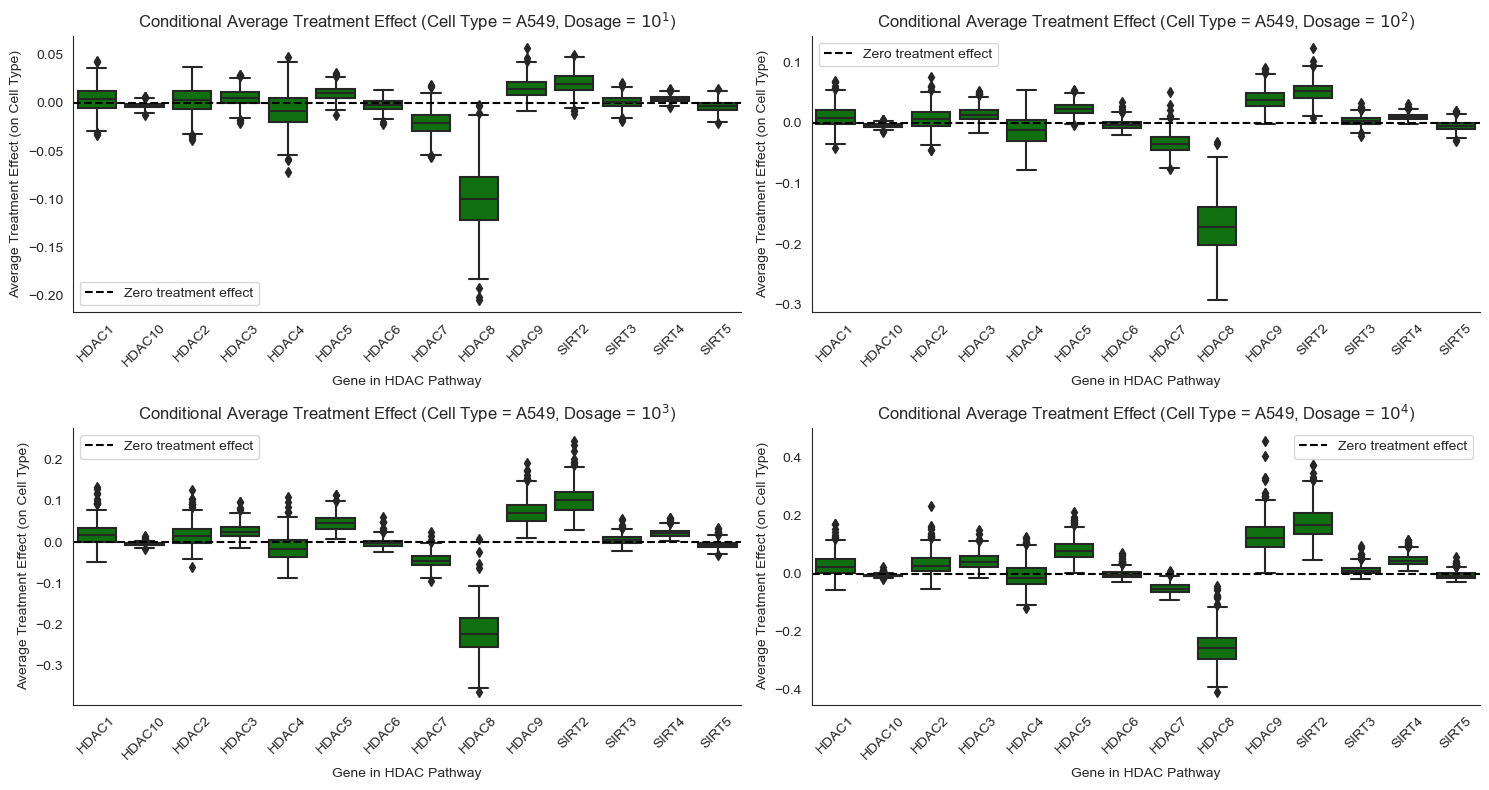

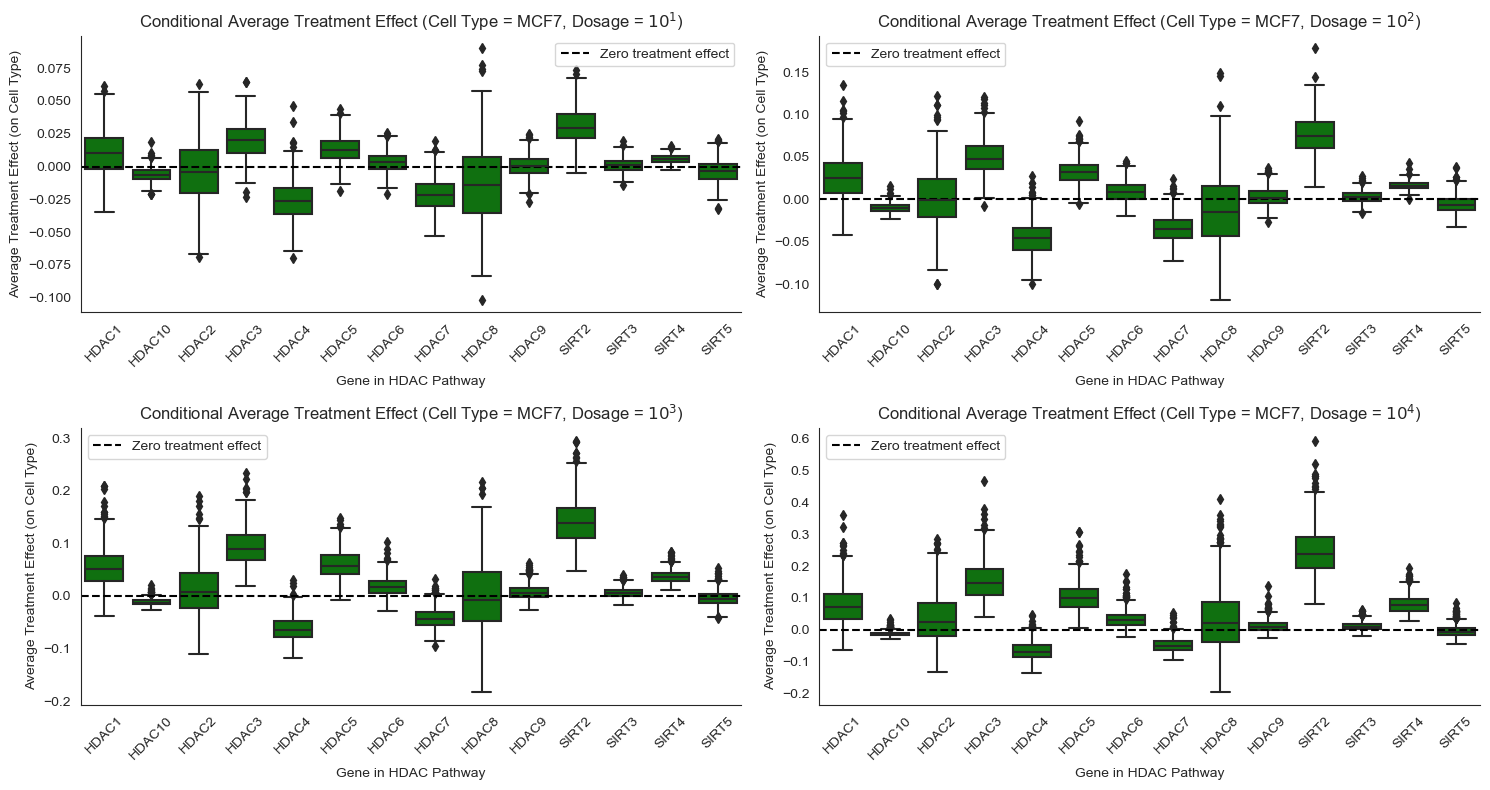

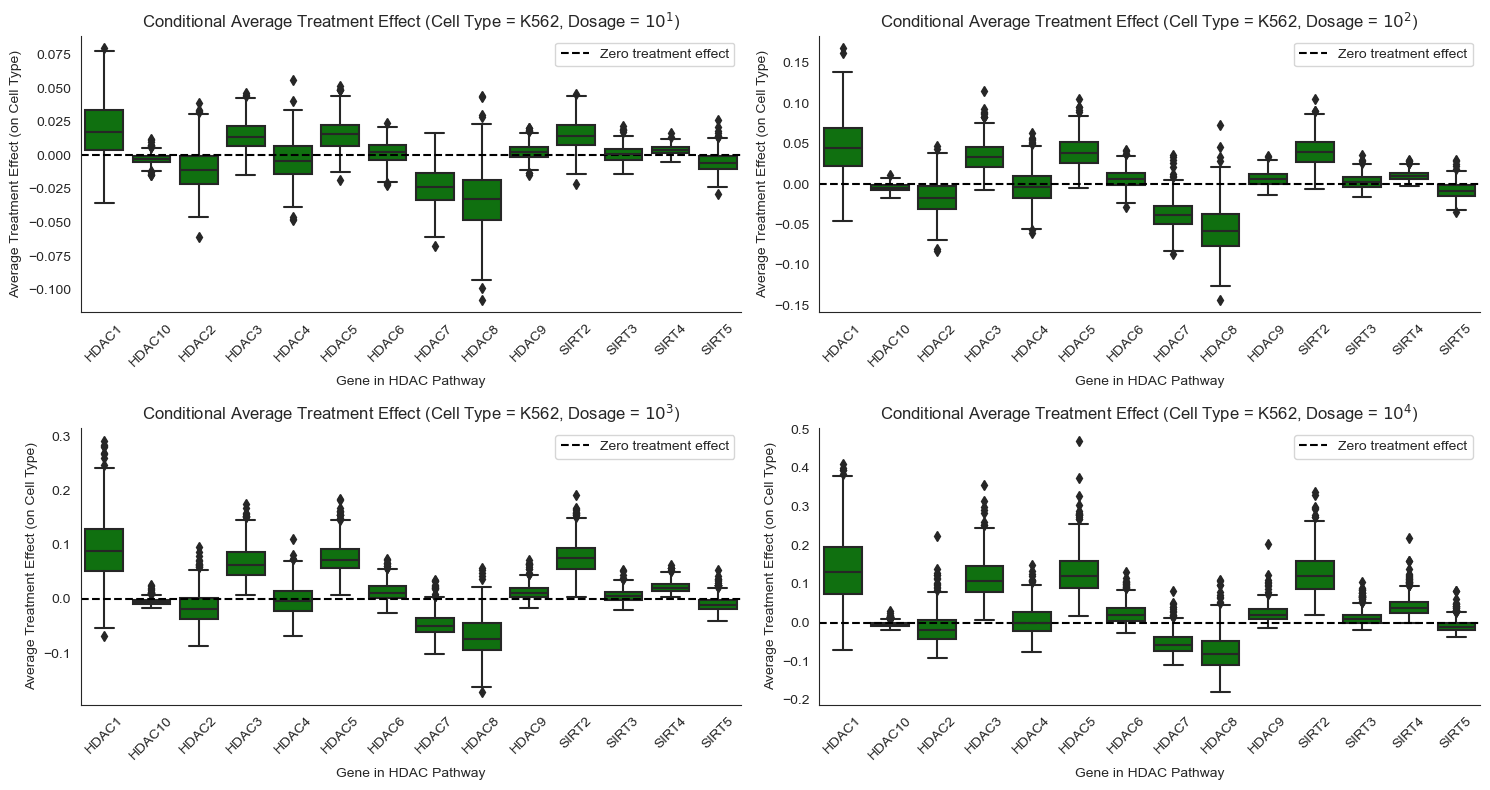

In [177]:
for cell_type in ['A549', 'MCF7', 'K562']:
    cell_type_mask = torch.tensor(hdac_adata.obs['cell_type'] == cell_type)[drug_control_mask]
    ates = [
        conditional_avg_treatment(po_1_prediction, po_0_prediction, cell_type_mask),
        conditional_avg_treatment(po_2_prediction, po_0_prediction, cell_type_mask),
        conditional_avg_treatment(po_3_prediction, po_0_prediction, cell_type_mask),
        conditional_avg_treatment(po_4_prediction, po_0_prediction, cell_type_mask),
    ]

    fig, ax = plt.subplots(2, 2, figsize=(15, 8))

    for i, dose_level in enumerate([1, 2, 3, 4]):
        curr_ax = ax[i // 2][i % 2]
        sns.boxplot(pd.DataFrame(ates[i], columns=hdac_genes), color='green', ax=curr_ax)
        curr_ax.set_title(f'Conditional Average Treatment Effect (Cell Type = {cell_type}, Dosage = $10^{dose_level}$)')
        curr_ax.axhline(0, color='black', linestyle='--', label='Zero treatment effect')
        curr_ax.set_xlabel('Gene in HDAC Pathway')
        for tick in curr_ax.get_xticklabels():
            tick.set_rotation(45)
        curr_ax.set_ylabel('Average Treatment Effect (on Cell Type)')
        curr_ax.legend()
        sns.despine()

    plt.tight_layout() 

# References

Sanjay R., Srivatsan et al., "Massively multiplex chemical transcriptomics at single-cell resolution". Science, 2020. https://www.science.org/doi/10.1126/science.aax6234

Hyun-Jung Kim, Suk-Chul Bae. "Histone deacetylase inhibitors: molecular mechanisms of action and clinical trials as anti-cancer drugs". American Journal of Translational Research, 2011. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3056563/

Guo Li, Yuan Tian, Wei-Guo Zhu. "The Roles of Histone Deacetylases and Their Inhibitors in Cancer Therapy". Frontiers in Cell and Developmental Biology, 2020. https://www.frontiersin.org/articles/10.3389/fcell.2020.576946/full

HUGO Gene Nomenclature Committee. Histone deacetylase superfamily. HGNC, 2020. https://www.genenames.org/data/genegroup/#!/group/937